# IE0005 Group 1
## Cuisine Prediction from Ingredients

In this notebook, we implement a prediction system that uses recipe-ingredient data from Kaggle challenge (https://www.kaggle.com/competitions/whats-cooking/data) to predict the cuisine of a given recipe

In [22]:
# Import the libraries

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn as sk


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier




In [23]:
recipe_data = pd.read_json('data/train.json')
recipe_data.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [24]:
# Check data type
print("Data type:", type(recipe_data))

# Check size of dataset
print('Data dim:', recipe_data.shape) 
print('Columns:', recipe_data.columns)

# Check variable types in dataset
print('\n', recipe_data.dtypes)

# Checking for null values in the data
print('\nWhether Null exists:\n', recipe_data.isnull().sum())

Data type: <class 'pandas.core.frame.DataFrame'>
Data dim: (39774, 3)
Columns: Index(['id', 'cuisine', 'ingredients'], dtype='object')

 id              int64
cuisine        object
ingredients    object
dtype: object

Whether Null exists:
 id             0
cuisine        0
ingredients    0
dtype: int64


In [25]:
recipe_data['ingredients_str'] = recipe_data['ingredients'].apply(lambda x: ', '.join(x))

# Check for duplicates based on 'cuisine' and 'ingredients_str' column
duplicate_rows = recipe_data.duplicated(subset=['cuisine', 'ingredients_str']).sum()
print("No. of duplicate rows:\n", duplicate_rows)

# Drop duplicate rows based on 'cuisine' and 'ingredients_str' columns, keeping the first occurrence
recipe_data = recipe_data.drop_duplicates(subset=['cuisine', 'ingredients_str'], keep='first')
# Reset index after dropping duplicates
recipe_data = recipe_data.reset_index(drop=True)
# Verify duplicate rows have been dropped
duplicate_rows = recipe_data.duplicated(subset=['cuisine', 'ingredients_str']).sum()
print("Remaining no. of duplicate rows:\n", duplicate_rows)

# Check for duplicates based on the 'id' column
duplicate_ids = recipe_data.duplicated(subset=['id']).sum()
print("No. of Duplicate IDs:\n", duplicate_ids)

print('New data dim:', recipe_data.shape) 
recipe_data.head(n = 10)

No. of duplicate rows:
 97
Remaining no. of duplicate rows:
 0
No. of Duplicate IDs:
 0
New data dim: (39677, 4)


,id,cuisine,ingredients,ingredients_str
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce, black olives, grape tomatoes,..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour, ground pepper, salt, tomatoes, gr..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs, pepper, salt, mayonaise, cooking oil, gr..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","water, vegetable oil, wheat, salt"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","black pepper, shallots, cornflour, cayenne pep..."
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...","plain flour, sugar, butter, eggs, fresh ginger..."
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli...","olive oil, salt, medium shrimp, pepper, garlic..."
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo...","sugar, pistachio nuts, white almond bark, flou..."
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por...","olive oil, purple onion, fresh pineapple, pork..."
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-...","chopped tomatoes, fresh basil, garlic, extra-v..."


In [26]:
# Find how many unique cuisines are there
print(recipe_data['cuisine'].nunique())

# What are the unique cuisines?
print(recipe_data['cuisine'].unique())

20
['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']


In [27]:
# Find how many recipes are there
recipe_data['ingredients']

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
                               ...                        
39672    [light brown sugar, granulated sugar, butter, ...
39673    [KRAFT Zesty Italian Dressing, purple onion, b...
39674    [eggs, citrus fruit, raisins, sourdough starte...
39675    [boneless chicken skinless thigh, minced garli...
39676    [green chile, jalapeno chilies, onions, ground...
Name: ingredients, Length: 39677, dtype: object

In [28]:
# Example of a single recipe column
recipe_data['ingredients'][4]

['black pepper',
 'shallots',
 'cornflour',
 'cayenne pepper',
 'onions',
 'garlic paste',
 'milk',
 'butter',
 'salt',
 'lemon juice',
 'water',
 'chili powder',
 'passata',
 'oil',
 'ground cumin',
 'boneless chicken skinless thigh',
 'garam masala',
 'double cream',
 'natural yogurt',
 'bay leaf']

In [29]:
# Count recipes for each cuisine
recipe_data['cuisine'].value_counts()

cuisine
italian         7831
mexican         6429
southern_us     4299
indian          2997
chinese         2666
french          2637
cajun_creole    1541
thai            1536
japanese        1417
greek           1172
spanish          987
korean           827
vietnamese       821
moroccan         818
british          803
filipino         755
irish            667
jamaican         522
russian          489
brazilian        463
Name: count, dtype: int64

<Axes: xlabel='cuisine', ylabel='count'>

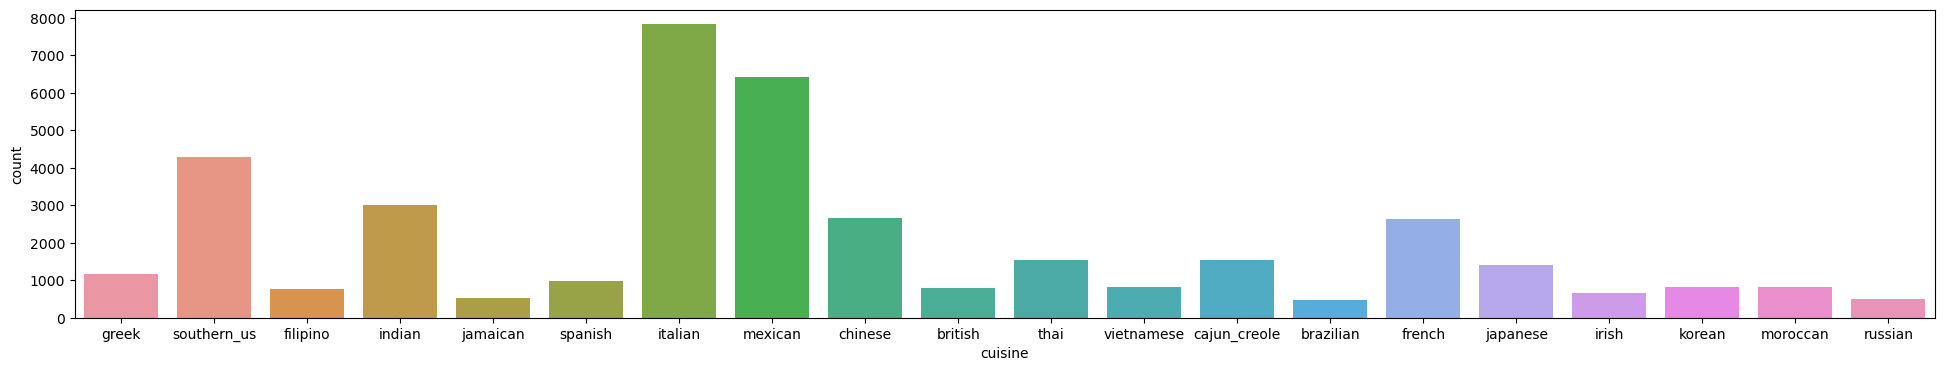

In [30]:
# Visualise on count plot
plt.figure(figsize=(24,4))
sb.countplot(x='cuisine', data=recipe_data)

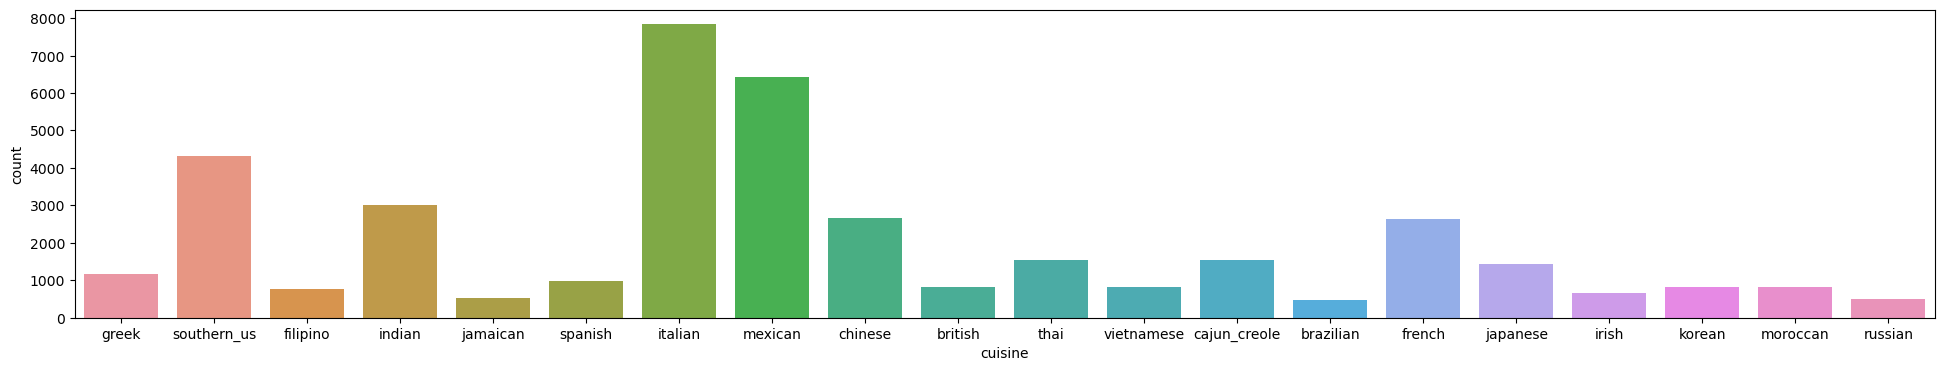

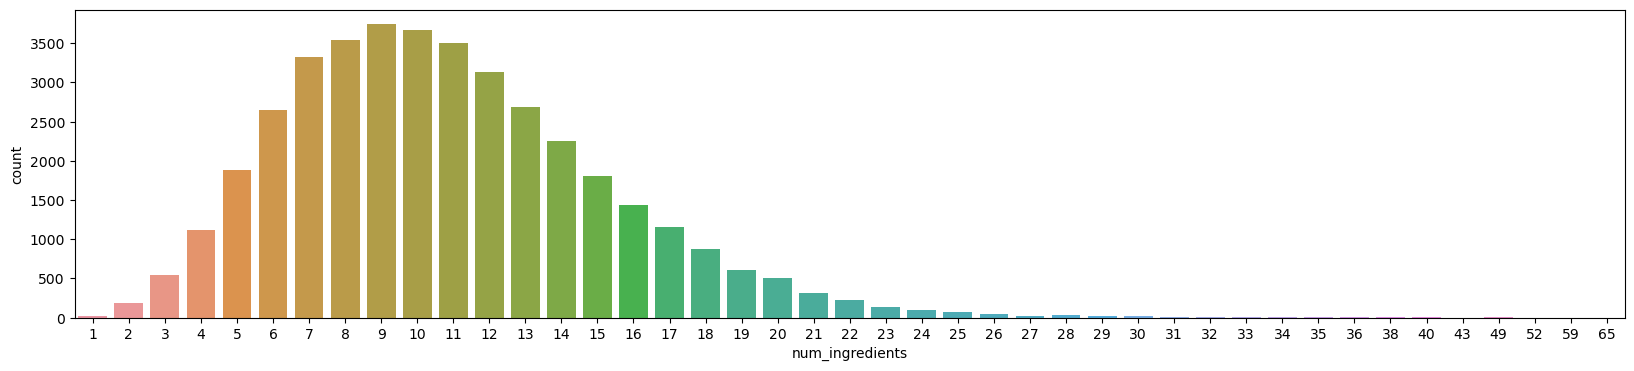

In [31]:
#
recipe_data['num_ingredients'] = recipe_data['ingredients'].apply(lambda x: len(x))

plt.figure(figsize=(20,4))
sb.countplot(x='num_ingredients', data=recipe_data)
plt.show()

In [32]:
recipe_data_exploded = recipe_data.explode('ingredients')

# How many unique ingredients are there?
print("Total no. of unique ingredients:", recipe_data_exploded['ingredients'].str.lower().nunique())
recipe_data_exploded_sorted = recipe_data_exploded.sort_values(by='ingredients').reset_index(drop=True)
print("Unique ingredients:", recipe_data_exploded_sorted['ingredients'].str.lower().unique()[:200])

Total no. of unique ingredients: 6703
Unique ingredients: ['(    oz.) tomato sauce' '(   oz.) tomato paste'
 '(10 oz.) frozen chopped spinach'
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry'
 '(14 oz.) sweetened condensed milk' '(14.5 oz.) diced tomatoes'
 '(15 oz.) refried beans' '1% low-fat buttermilk'
 '1% low-fat chocolate milk' '1% low-fat cottage cheese' '1% low-fat milk'
 '2 1/2 to 3 lb. chicken, cut into serving pieces'
 '2% low fat cheddar chees' '2% low-fat cottage cheese'
 '2% lowfat greek yogurt' '2% milk shredded mozzarella cheese'
 '2% reduced-fat milk' '25% less sodium chicken broth'
 '33% less sodium cooked deli ham' '33% less sodium cooked ham'
 '33% less sodium ham' '33% less sodium smoked fully cooked ham'
 '40% less sodium taco seasoning' '40% less sodium taco seasoning mix'
 '7 up' '8 ounc ziti pasta, cook and drain' '95% lean ground beef'
 'a taste of thai rice noodles' 'accent seasoning'
 'adobo all purpose seasoning' 'alaskan king crab legs'
 'alexia

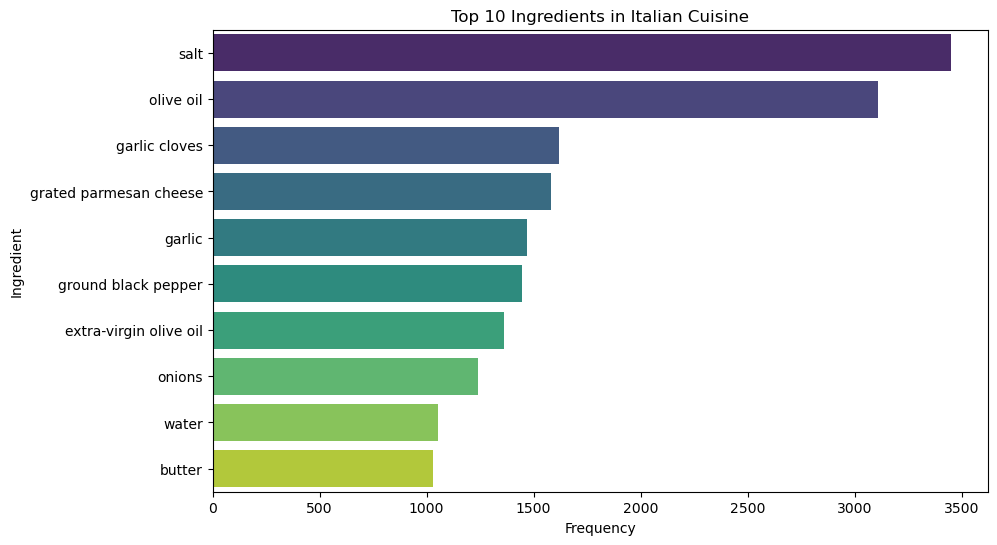

In [33]:
def plot_top_ingredients(cuisine, top_n=10):
    top_ingredients = (recipe_data_exploded[recipe_data_exploded['cuisine'] == cuisine].value_counts('ingredients').head(top_n))

    plt.figure(figsize=(10, 6))
    sb.barplot(x=top_ingredients.values, y=top_ingredients.index, palette='viridis')
    plt.title(f"Top {top_n} Ingredients in {cuisine.capitalize()} Cuisine")
    plt.xlabel("Frequency")
    plt.ylabel("Ingredient")
    plt.show()

plot_top_ingredients('italian')

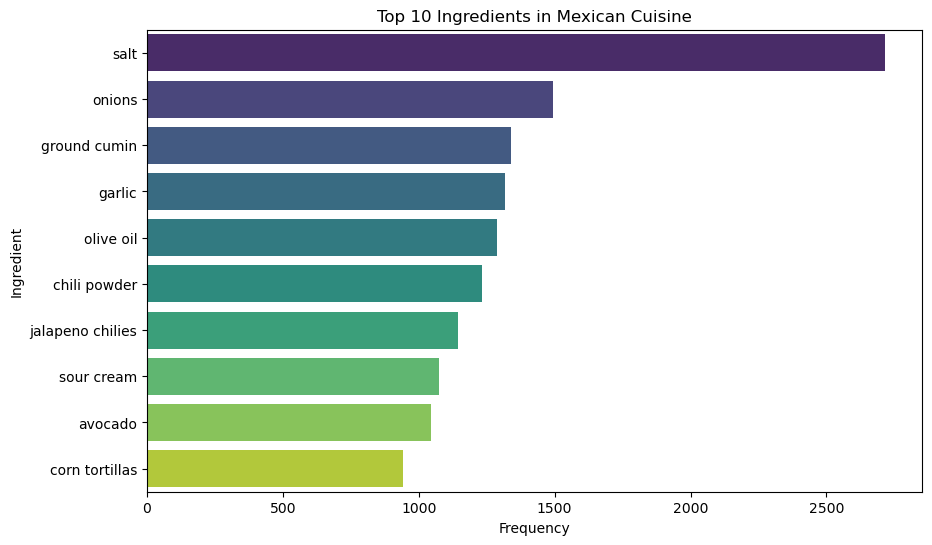

In [34]:
plot_top_ingredients('mexican')

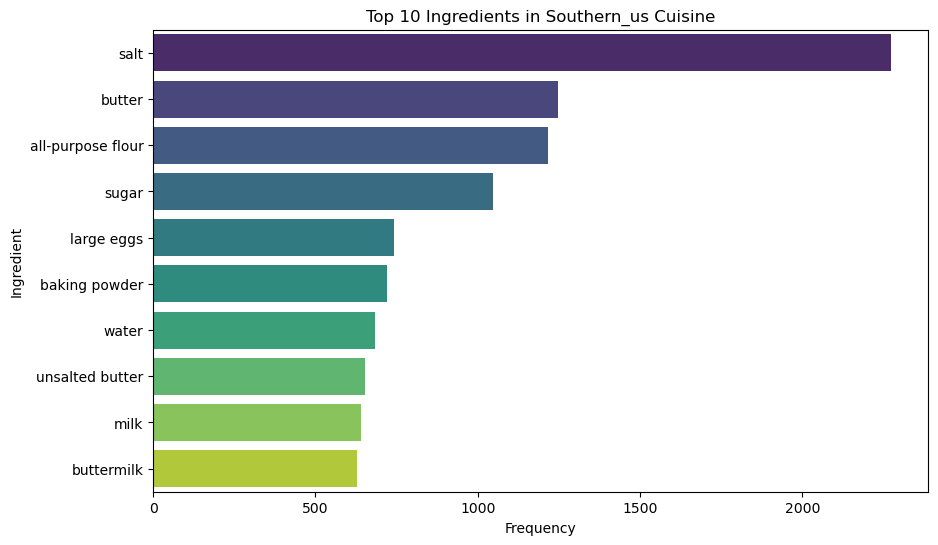

In [35]:
plot_top_ingredients('southern_us')

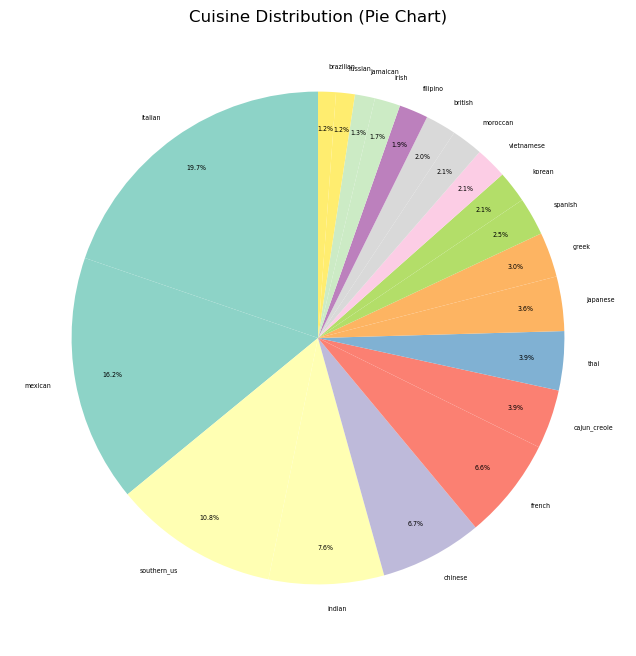

In [36]:
def plot_cuisine_distribution_pie():
    plt.figure(figsize=(8, 8))
    fig = recipe_data['cuisine'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3', pctdistance = 0.85)
    plt.setp(fig.texts, size = 4.5)
    plt.title('Cuisine Distribution (Pie Chart)')
    plt.ylabel('')
    plt.show()

plot_cuisine_distribution_pie()

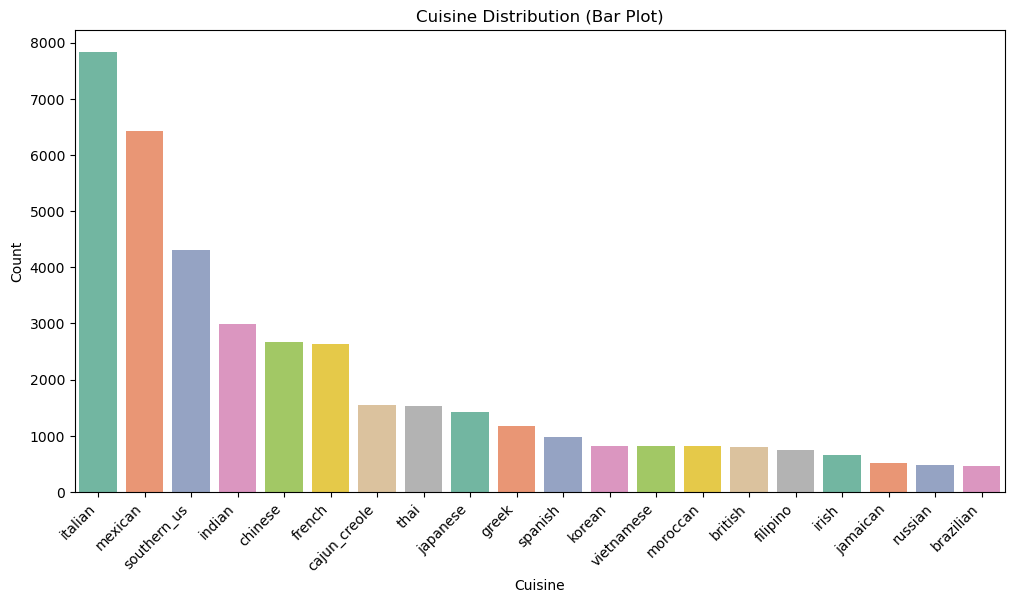

In [37]:
def plot_cuisine_distribution_bar():
    plt.figure(figsize=(12, 6))
    sb.countplot(data=recipe_data, x='cuisine', order=recipe_data['cuisine'].value_counts().index, palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.title('Cuisine Distribution (Bar Plot)')
    plt.xlabel('Cuisine')
    plt.ylabel('Count')
    plt.show()

plot_cuisine_distribution_bar()

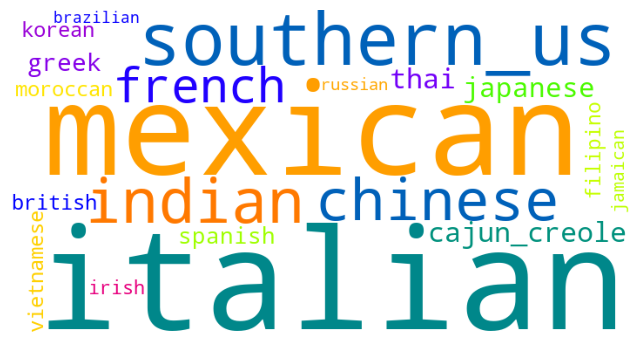

In [38]:
# Install wordcloud library
%pip install wordcloud

# Generate wordcloud, largest size -> most number of recipes
from wordcloud import WordCloud

x = recipe_data['cuisine'].values

plt.subplots(figsize = (8,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 712,
                    height = 384,
                    colormap = 'prism').generate(' '.join(x))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.savefig('cuisines.png')
plt.show()

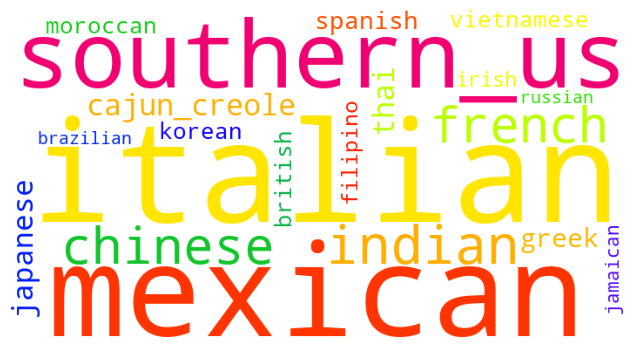

In [17]:
X = pd.DataFrame(recipe_data['ingredients'])
y = pd.DataFrame(recipe_data['cuisine'])

# Split into test (25%) & training sets (75%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Convert to NumPy array and flatten into 1D array
y_train_flat = y_train.values.flatten()
y_test_flat = y_test.values.flatten()

# Check the sample sizes
print("Train Set:", X_train.shape, y_train_flat.shape)
print("Test Set:", X_test.shape, y_test_flat.shape)

Train Set: (29757, 1) (29757,)
Test Set: (9920, 1) (9920,)


In [18]:
# Step 1: Transform train & test sets
# Join ingredients into a single string with , for each recipe
X_train['ingredients-str'] = X_train['ingredients'].apply(lambda x:  ', '.join(x))
X_test['ingredients-str'] = X_test['ingredients'].apply(lambda x:  ', '.join(x))

# Step 2: Feature Engineering (NLP) into bag of words
# Custom tokenizer function (splits ingredient names separated by commas)
def custom_tokenizer(text):
    # Split the input string by comma, remove extra spaces, and return the list of ingredients
    return [ingredient.strip() for ingredient in text.split(",")]

vectoriser = CountVectorizer(tokenizer = custom_tokenizer)

X_train_bow = vectoriser.fit_transform(X_train['ingredients-str']).toarray()
X_test_bow = vectoriser.transform(X_test['ingredients-str']).toarray()

print(vectoriser.get_feature_names_out()[300:400])
print(X_train_bow)
print(X_train_bow.shape)
# Case sensitivity, punctuation handling, whitespace, and duplicates 
# are the primary reasons why explode() and CountVectorizer show different results

c:\Users\Rayson\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['banh pho rice noodles' 'baobab fruit powder' 'barbecue rub'
 'barbecue sauce' 'barbecue seasoning' 'barbecued pork' 'barilla'
 'barilla linguine' 'barilla oven-ready lasagne' 'barilla plus pasta'
 'barley' 'barley flakes' 'barley flour' 'barley grits' 'barley miso'
 'barolo' 'bartlett pear' 'bartlett pears' 'base' 'basil'
 'basil dried leaves' 'basil leaves' 'basil mayonnaise' 'basil olive oil'
 'basil pesto sauce' 'basmati' 'basmati rice' 'bass' 'bass fillets'
 'baton' 'batter' 'bawang goreng' 'bay leaf' 'bay leaves' 'bay scallops'
 'bbq sauce' 'bbq seasoning' 'bean curd' 'bean curd skins' 'bean dip'
 'bean paste' 'bean sauce' 'bean soup' 'bean soup mix'
 'bean thread vermicelli' 'bean threads' 'beans' 'beansprouts' 'bear'
 'beaten eggs' 'beau monde seasoning' 'beaujolais' 'bechamel' 'bee pollen'
 'beef' 'beef base' 'beef boneless meat stew' 'beef bones' 'beef bouillon'
 'beef bouillon granules' 'beef bouillon powder' 'beef brisket'
 'beef broth' 'beef carpaccio' 'beef consomme'
 'b

In [ ]:
# # Create a Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42)

# too many trees, by default 100


# # These are hyper parameters to be specified in the model
# rf_param_dist = {
#     'n_estimators': [100, 200, 300],  # Number of trees in the forest
#     'max_depth': [10, 20, 30, None],  # Maximum depth of the trees
#     'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
#     'min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
#     'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
# }


# # Initialize RandomizedSearchCV for Random Forest
# random_search_rf = RandomizedSearchCV(
# estimator=rf_model,  # Random Forest model
# param_distributions=rf_param_dist,  # The parameter grid we defined earlier
# n_iter=10,  # Number of different combinations to try
# cv=2,  # Cross-validation with 5 folds
# random_state=42,  # For reproducibility
# verbose=2  # Show detailed output of the search process
# )

# # Fit RandomizedSearchCV on the training data
#random_search_rf.fit(X_train_bow, y_train_flat)
rf_model.fit(X_train_bow, y_train_flat)

# # Access the best model
# best_rf_model = random_search_rf.best_estimator_

# # Use the best model to make predictions
#y_pred = best_rf_model.predict(X_test_bow)
y_pred_rf = rf_model.predict(X_test_bow)

# # Accuracy score
print("Accuracy of the best model:", accuracy_score(y_test_flat, y_pred_rf))

# # Detailed classification report
print(classification_report(y_test_flat, y_pred_rf))

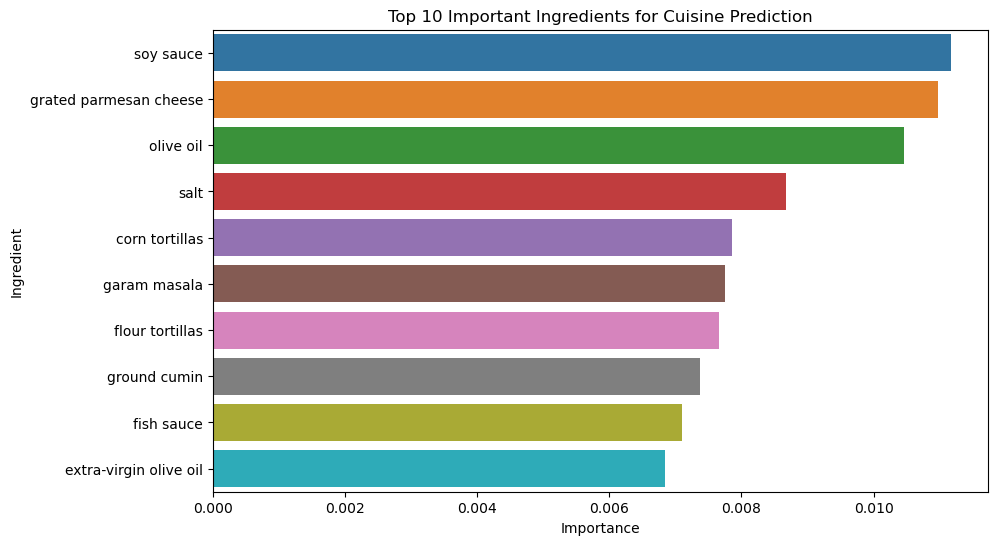

In [20]:
#Check for importance of ingredients for RandomForest model (Feature Importance)

importances = rf_model.feature_importances_
feature_names = vectoriser.get_feature_names_out()


importance_df = pd.DataFrame({'Ingredient': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10,6))
sb.barplot(x="Importance",y="Ingredient", data=importance_df.head(10))
plt.title('Top 10 Important Ingredients for Cuisine Prediction')
plt.show()


In [ ]:
# import logistic regression
from sklearn.linear_model import LogisticRegression


# Define the hyperparameters for Logistic Regression
# logreg_param_dist = {
#     'C': np.logspace(-4, 4, 20),  # Regularization strength (log scale)
#     'penalty': ['l2', 'elasticnet'],  # Regularization type
#     'solver': ['lbfgs', 'liblinear', 'saga'],  # Solver to use
#     'max_iter': [100, 200, 300],  # Maximum number of iterations for the solver
#     'l1_ratio': [0, 0.5, 1]  # ElasticNet penalty term (only for 'elasticnet' penalty)
# }


#Set up and fit logistic regression
logreg_model = LogisticRegression(random_state=42,max_iter=300).fit(X_train_bow, y_train_flat)


# # Set up RandomizedSearchCV with 5-fold cross-validation and 10 candidates
# random_search_logreg = RandomizedSearchCV(
#     estimator=logreg_model,
#     param_distributions=logreg_param_dist,
#     n_iter=10,  # Number of candidates to test
#     cv=2,  # 5-fold cross-validation for evaluation
#     random_state=42,
#     verbose=2  # Show detailed output for each step
# )


# Fit the model
#random_search_logreg.fit(X_train_bow, y_train_flat)
logreg_model.fit(X_train_bow, y_train_flat)

# # Access the best model
# best_logreg_model = random_search_logreg.best_estimator_

# Use model to make predictions on test data
y_pred_logreg = logreg_model.predict(X_test_bow)

# Evaluate the predictions
print("Accuracy of Logistic Regression model:", accuracy_score(y_test_flat, y_pred_logreg))
print(classification_report(y_test_flat, y_pred_logreg))

Text(50.722222222222214, 0.5, 'True')

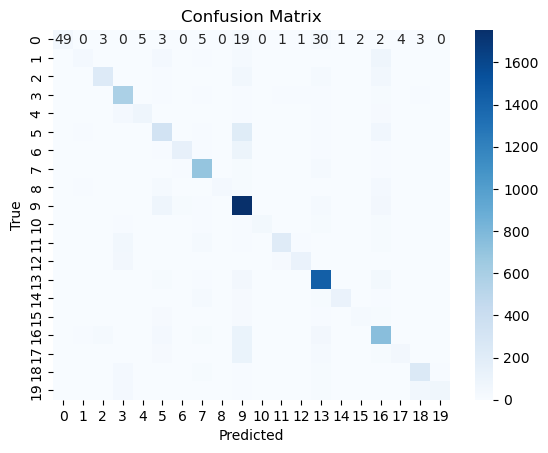

In [ ]:
# Model Evaluation
# Plot the Confusion Matrix for both models
f, axes = plt.subplots(2, 1, figsize=(12, 24))
sb.heatmap(confusion_matrix(y_test_flat, y_pred_rf),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_flat, y_pred_logreg), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
# confuse = confusion_matrix(y_test, y_pred)
# sb.heatmap(confuse, annot = True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# # plt.show()

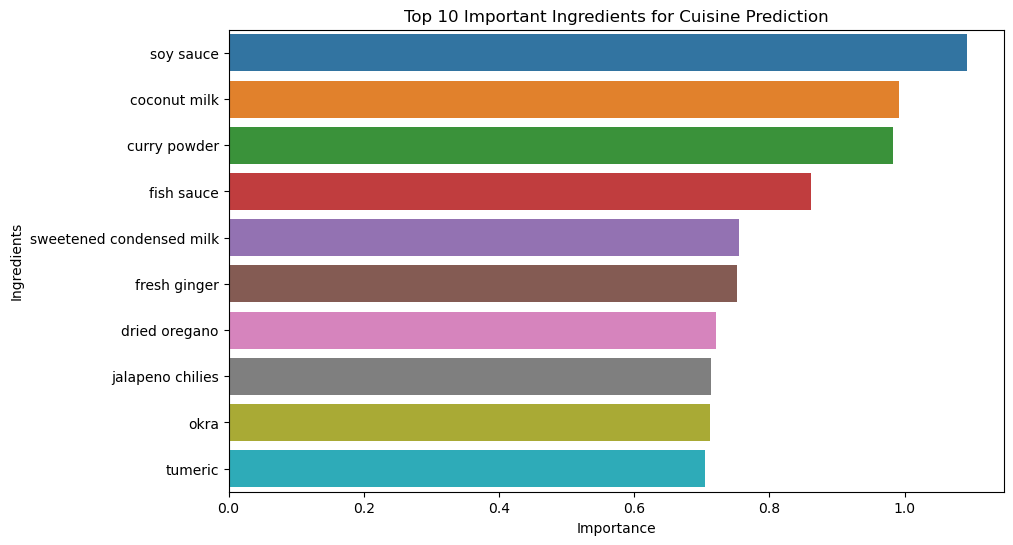

In [31]:
# Check for importance of ingredients for Log Reg model (Feature Importance)
coefficients = logreg_model.coef_


# Calculate feature importance by taking the average of the absolute values of the coefficients across all classes.
avg_importance = np.mean(np.abs(coefficients), axis = 0)
feature_names = vectoriser.get_feature_names_out()

feature_importance = pd.DataFrame({"Ingredients": feature_names, "Importance": avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
#feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.figure(figsize=(10,6))
sb.barplot(x = "Importance", y = "Ingredients", data= feature_importance.head(10))
plt.title('Top 10 Important Ingredients for Cuisine Prediction')
plt.show()